# Detection of Stomach or Intestine in Medial Images Using ResNet50V2

In [1]:
#!pip install tensorflow
#!pip install tensorflow-gpu
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from IPython.display import clear_output
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, roc_curve
from livelossplot import PlotLossesKeras
from keras.models import load_model, Model
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam

# Constants and Hyperparameters

In [2]:
# Define hyperparameters and constants
BATCH_SIZE = 32
EPOCHS = 30
LEARN_RATE = 0.001

MEAN = 0.136
STD = 0.178

IM_SIZE = 288

# Evaluation Functions

In [24]:
# Function for custom normalization
def custom_normalization(image):
    image_rgb = np.repeat(image, 3, axis=-1)
    image = image / 255.0
    image = (image - MEAN) / STD
    return image


# ploting model loss during training, created by Daniel: https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5
class plot_learning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()


def find_roc_threshold_tpr(y, y_pred, value_target):
    """
    This function calculates the threshold and false positive rate corresponding to a true positive rate of value_target (from 0 to 1).
       
    y                     # Real labels
    y_pred                # Predicted labels
    value_target          # False positive rate value
    
    Returns:
    
    threshold             # Threshold value
    true_positive_rate   # True positive rate value
    """

    fpr, tpr, thr = roc_curve(y, y_pred)

    old_diff = 100000000
    for index, value in enumerate(tpr):
        new_diff = abs(value_target - value)
        if new_diff < old_diff:
            false_pos_rate = fpr[index]
            threshold = thr[index]
            old_diff = new_diff

    return threshold, false_pos_rate

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Binary Classification Model

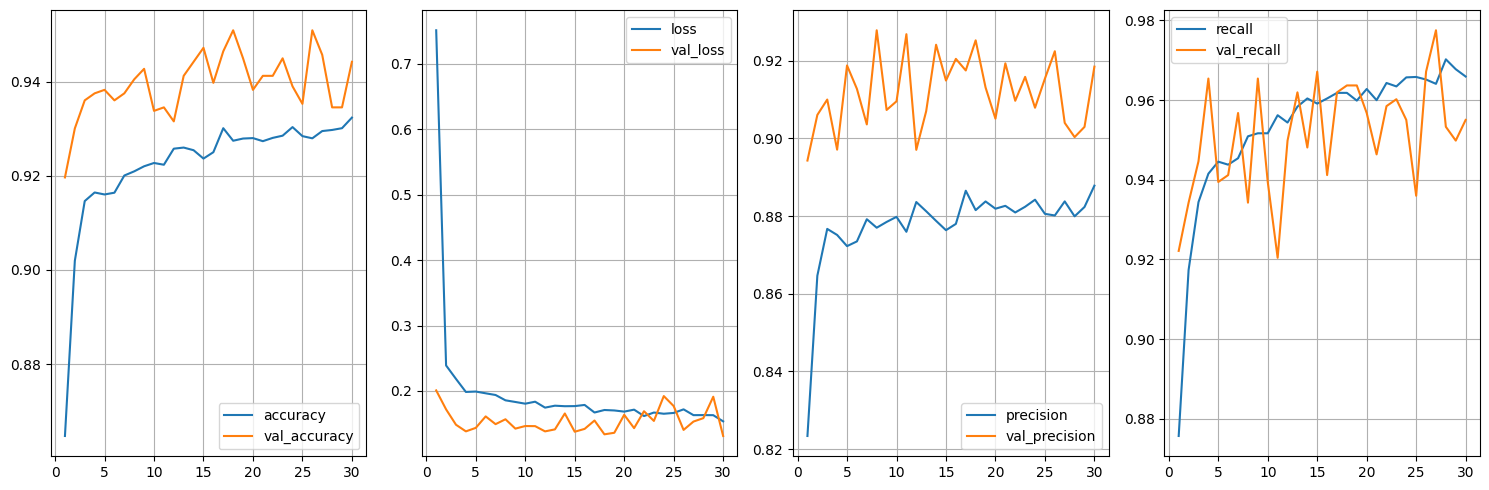

669/669 ━━━━━━━━━━━━━━━━━━━━ 1001s 1s/step - accuracy: 0.9328 - loss: 0.1533 - precision: 0.8899 - recall: 0.9661 - val_accuracy: 0.9442 - val_loss: 0.1313 - val_precision: 0.9185 - val_recall: 0.9550


In [4]:
# Preprocess the images and create data generators with augmentation and normalization
train_datagen = ImageDataGenerator(
    preprocessing_function = custom_normalization,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function = custom_normalization)

train_generator = train_datagen.flow_from_directory(
    'dataset_UWM_GI_Tract_classification/train',
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    'dataset_UWM_GI_Tract_classification/valid',
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    'dataset_UWM_GI_Tract_classification/test',
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Load the pre-trained ResNet50 model
#wgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
#resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

# Freeze the layers in the base model
for layer in resnet_base.layers:
    layer.trainable = False

# Get the output tensor of the base ResNet50V2 model
resnet_output = resnet_base.output

# Flatten the output tensor
flattened_output = Flatten()(resnet_output)

# Add the fully connected layers: 1 layer with 256 neurons and the output layer with a sigmoid function
deep_layers = Dense(256, kernel_initializer=glorot_uniform(seed=42), activation='relu')(flattened_output)
dropout = Dropout(0.5)(deep_layers)
output = Dense(1, activation='sigmoid')(dropout)

# Create the model
model = Model(inputs=resnet_base.input, outputs=output)

# Compile de model
optimizer = Adam(learning_rate=LEARN_RATE)
eval_metrics = [tf.keras.metrics.Precision(thresholds=0.5), tf.keras.metrics.Recall(thresholds=0.5), "accuracy"]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=eval_metrics)

#class_0 = 15149
#class_1 = 11585
#w_0 = (1 / class_0) * ((class_0 + class_1) / 2.0)
#w_1 = (1 / class_1) * ((class_0 + class_1) / 2.0)
#print(w_0, w_1)
#class_weight = {0: w_0, 1: w_1}

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Train the model
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,    
    epochs=EPOCHS,
    #validation steps=
    #steps_per_epoch
    verbose=1,
    validation_data=validation_generator,    
    #class_weight=class_weight,
    callbacks=plot_learning()
)

In [9]:
# Save model
#model.save("resnet50v2_nn256_lr0001_relu_batch32_epoch20.keras")
model.save("resnet50v2_nn256_lr0001_relu_batch32_epoch30.keras")

In [10]:
# Load model
model_1 = load_model('resnet50v2_nn256_lr0001_relu_batch32_epoch20.keras')
model_2 = load_model('resnet50v2_nn256_lr0001_relu_batch32_epoch30.keras')

In [7]:
# Evaluate  model
#test_loss, test_acc = model.evaluate(test_generator, batch_size=batch_size)
#print('Test accuracy:', test_acc)

# Evaluation

In [12]:
# Make predictions
#y_pred_1 = model_1.predict(test_generator)
y_pred_2 = model_2.predict(test_generator)
y_pred_1.reshape(-1)
y_pred_2.reshape(-1)
y_test = test_generator.labels

158/158 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step


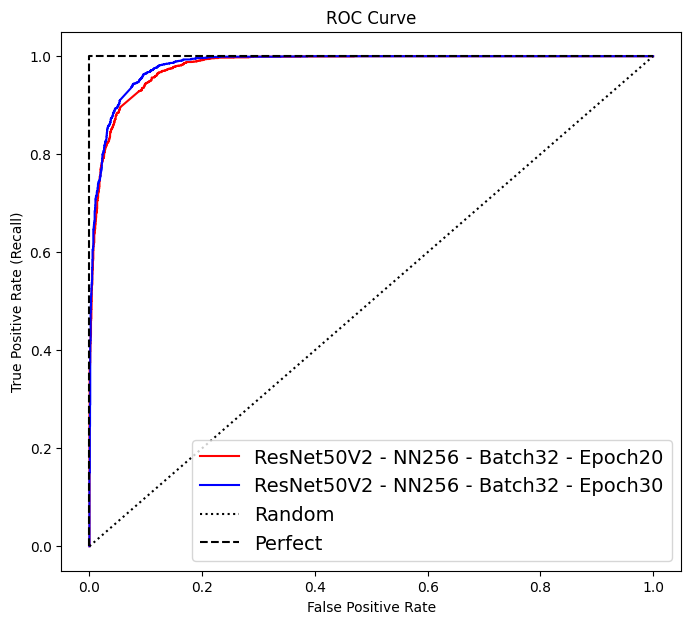

In [13]:
# Plot ROC curves
fpr1, tpr1, thr_roc1 = roc_curve(y_test, y_pred_1)
fpr2, tpr2, thr_roc2 = roc_curve(y_test, y_pred_2)
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot()
plt.plot(fpr1, tpr1, 'r-', label = 'ResNet50V2 - NN256 - Batch32 - Epoch20')
plt.plot(fpr2, tpr2, 'b-', label = 'ResNet50V2 - NN256 - Batch32 - Epoch30')
plt.plot([0,1],[0,1],'k:', label = 'Random')
plt.plot([0,0,1,1,],[0,1,1,1],'k--', label='Perfect')
plt.legend(fontsize=14)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

In [26]:
# Compute the threshold to achieve a 99% recall
recall = 0.995
thr, fpr = find_roc_threshold_tpr(y_test, y_pred_2, recall)
print(f"Threshold for {round(100*recall, 2)}% recall: {thr}")
print(f"False Positive Rate: {round(100*fpr, 2)}%")

Threshold for 99.5% recall: 0.02974667027592659
False Positive Rate: 18.18%


Normalized confusion matrix


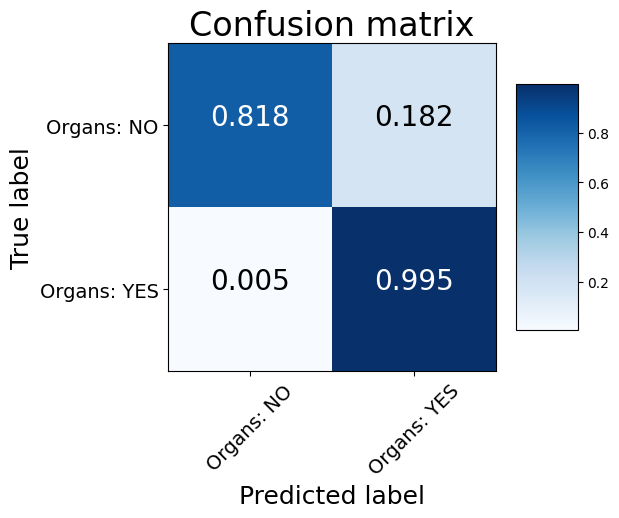

In [27]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_2 >= 0.0297)
plot_confusion_matrix(cm,
                      ['Organs: NO', 'Organs: YES'],
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues,
                      figsize=(6,6))

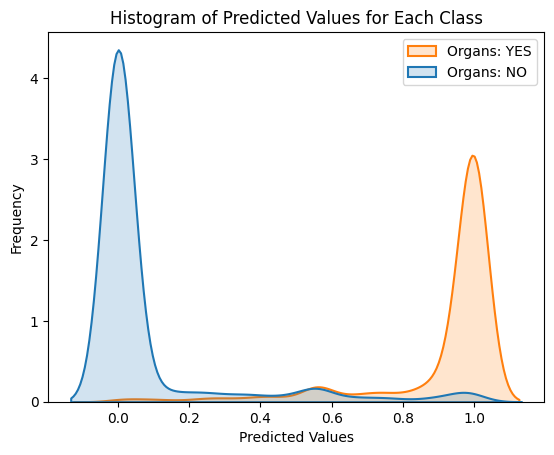

In [16]:
import seaborn as sns

# Create a DataFrame with predicted values and true labels
df = pd.DataFrame({'Predicted': list(y_pred_2), 'Real': list(y_test)})
df.Predicted = df.Predicted.astype(float)
df.Real = df.Real.astype(int)

## Plot histograms
sns.kdeplot(data=df, x='Predicted', hue='Real', fill=True, alpha=0.2, linewidth=1.5)
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Values for Each Class')
plt.legend(labels=['Organs: YES', 'Organs: NO'])
plt.show()

As observed in the figure, the CNN model is able to clearly separate the two classes.